# 🧠 BCI: Decoding EEG Signals for MI & SSVEP Tasks ⚡️
### A comprehensive solution for the MTCAIC3 Kaggle competition, leveraging domain-specific algorithms like CSP and CCA to classify brain signals.

### 🎯 1. Introduction & Competition Goal
#### This notebook presents an end-to-end solution for the MTCAIC3 Brain-Computer Interface (BCI) competition. The primary goal is to classify Electroencephalography (EEG) signals recorded from human subjects performing two distinct mental tasks:

#### Motor Imagery (MI): The subject imagines performing a physical movement (e.g., moving their left or right hand).

#### Steady-State Visually Evoked Potentials (SSVEP): The subject focuses on a visual stimulus flickering at a specific frequency.

#### Our objective is to build robust machine learning pipelines tailored to the unique characteristics of each task to achieve the highest possible classification accuracy.

### 🗺️ 2. Overall Strategy & Pipeline Architecture
#### The MI and SSVEP tasks are fundamentally different and require specialized signal processing and machine learning techniques. Therefore, our strategy is to build two independent, optimized pipelines:

#### Motor Imagery (MI) Pipeline:

Bandpass Filter → Common Spatial Patterns (CSP) for Feature Extraction → Linear Discriminant Analysis (LDA) for Classification.

SSVEP Pipeline:

Bandpass Filter → Canonical Correlation Analysis (CCA) for Classification.

####  We will use StratifiedGroupKFold cross-validation to ensure our models generalize well across different subjects and to prevent data leakage.

# 🛠️ 3. Setup & Data Loading
### First, let's set up the environment, import the necessary libraries, and load the competition data.

In [1]:
import pandas as pd
import numpy as np
import os

# Add this import for signal processing
from scipy.signal import butter, filtfilt #it's a standard for scientific computing in Python.

# Load index files
base_path = "/kaggle/input/mtcaic3" 
train_df = pd.read_csv(os.path.join(base_path, 'train.csv'))
validation_df = pd.read_csv(os.path.join(base_path, 'validation.csv'))
test_df = pd.read_csv(os.path.join(base_path, 'test.csv'))

# Combine them into a single dataframe
full_train_df = pd.concat([train_df, validation_df], ignore_index=True)

# 🔬 4. EEG Signal Preprocessing: Bandpass Filtering
### Raw EEG signals are often noisy. A crucial first step is to apply a bandpass filter to isolate the frequency bands that contain the most relevant information for our tasks and remove noise like muscle artifacts and line noise.

### Why different filters?

Motor Imagery (MI) signals are most prominent in the alpha (8-12 Hz) and beta (13-30 Hz) frequency bands. We'll use a filter of 8-30 Hz.

SSVEP signals are directly tied to the flicker frequencies of the visual stimuli. A wider filter of 4-40 Hz is more appropriate here.

In [2]:
def bandpass_filter(data, low_cut=4.0, high_cut=40.0, fs=250, order=5):
    """Applies a bandpass filter to the EEG data."""
    nyq = 0.5 * fs
    low = low_cut / nyq
    high = high_cut / nyq
    b, a = butter(order, [low, high], btype='band')
    
    # Apply the filter to the 8 EEG channels (columns 1 to 9)
    eeg_channels = data.columns[1:9]
    filtered_data = data.copy()
    filtered_data[eeg_channels] = filtfilt(b, a, data[eeg_channels], axis=0)
    
    return filtered_data

In [3]:
def load_trial_data_verbose(row, base_path='.'):
    import pandas as pd

    # Determine dataset split 
    id_num = row['id']
    if id_num <= 4800:
        dataset_split = 'train'
    elif id_num <= 4900:
        dataset_split = 'validation'
    else:
        dataset_split = 'test'

    # Determine the full path to the EEG file 
    eeg_file_path = f"{base_path}/{row['task']}/{dataset_split}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    session_eeg_data = pd.read_csv(eeg_file_path)

    # Determine the start and end of the trial 
    trial_num = int(row['trial'])
    samples_per_trial = 2250 if row['task'] == 'MI' else 1750
    start_index = (trial_num - 1) * samples_per_trial
    end_index = start_index + samples_per_trial

    # Extract the specific trial data 
    trial_data = session_eeg_data.iloc[start_index:end_index]

    # Show details 
    print("Trials Details:")
    print(f"- Task: {row['task']}")
    print(f"- Subject: {row['subject_id']}")
    print(f"- Session: {row['trial_session']}")
    print(f"- Trial #: {row['trial']}")
    if 'label' in row:
        print(f"- Label (Target): {row['label']}")
    else:
        print(f"- Label (Target): Not Available (Test set)")
    print(f"- Dataset Split: {dataset_split}")
    print(f"- File Path: {eeg_file_path}")
    print(f"- Data Shape: {trial_data.shape}")
    print()

    return trial_data


Trials Details:
- Task: MI
- Subject: S1
- Session: 1
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S1/1/EEGdata.csv
- Data Shape: (2250, 18)

First 5 rows of EEG signals:
            Time             FZ             C3            CZ            C4  \
0  471108.629297  259145.062500  255463.203125  280156.78125  297592.40625   
1  471108.634537  259071.937500  255626.625000  282968.28125  297913.18750   
2  471108.634549  259450.296875  255598.296875  283131.25000  297802.50000   
3  471108.636824  259770.734375  255431.093750  280456.65625  297436.09375   
4  471108.639355  259562.062500  255346.515625  278669.31250  297312.09375   

             PZ            PO7             OZ            PO8      AccX  \
0  268555.25000  255108.156250  232334.953125  239896.906250 -0.156006   
1  269795.59375  255109.765625  232506.515625  240036.203125 -0.143799   
2  269435.43750  255080.796875  232323.593750  239907.625000 -0.137451   
3  267

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

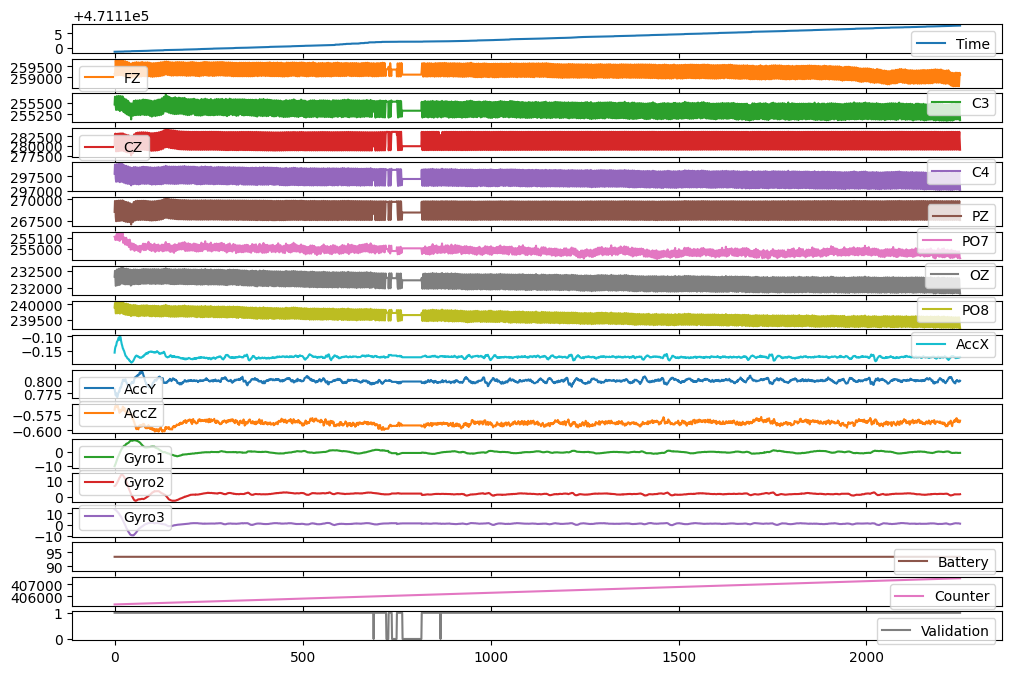

In [4]:
trial_row = full_train_df.iloc[0]  

eeg_data = load_trial_data_verbose(trial_row, base_path=base_path)

print("First 5 rows of EEG signals:")
print(eeg_data.head())
import matplotlib.pyplot as plt
eeg_data.plot(subplots=True, figsize=(12, 8))



2. Applying Band-Pass Filter
Applied MI filter (8-30 Hz).

Filtered EEG Data (first 5 rows):
            Time          FZ         C3          CZ        C4         PZ  \
0  471108.629297   14.235766   0.123490    1.131000 -4.326787 -13.308933   
1  471108.634537  117.420352  11.422974  385.977858  1.356696  26.821497   
2  471108.634549  191.107769  19.464149  661.382801  5.348682  55.105530   
3  471108.636824  217.220507  22.456319  761.812101  6.920800  65.184339   
4  471108.639355  195.351788  20.650919  686.987634  6.466627  57.924583   

         PO7         OZ        PO8      AccX      AccY      AccZ      Gyro1  \
0  -0.791290  -6.307667  -4.276654 -0.156006  0.782959 -0.566162 -10.437011   
1  -8.880197 -41.465437 -25.796343 -0.143799  0.778809 -0.562500  -9.582519   
2 -14.693799 -66.761658 -41.515322 -0.137451  0.773926 -0.560303  -9.185790   
3 -16.718648 -75.902462 -47.614976 -0.133545  0.770508 -0.560303  -8.483886   
4 -14.649839 -68.314500 -43.535077 -0.132324  0.774902

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
      dtype=object)

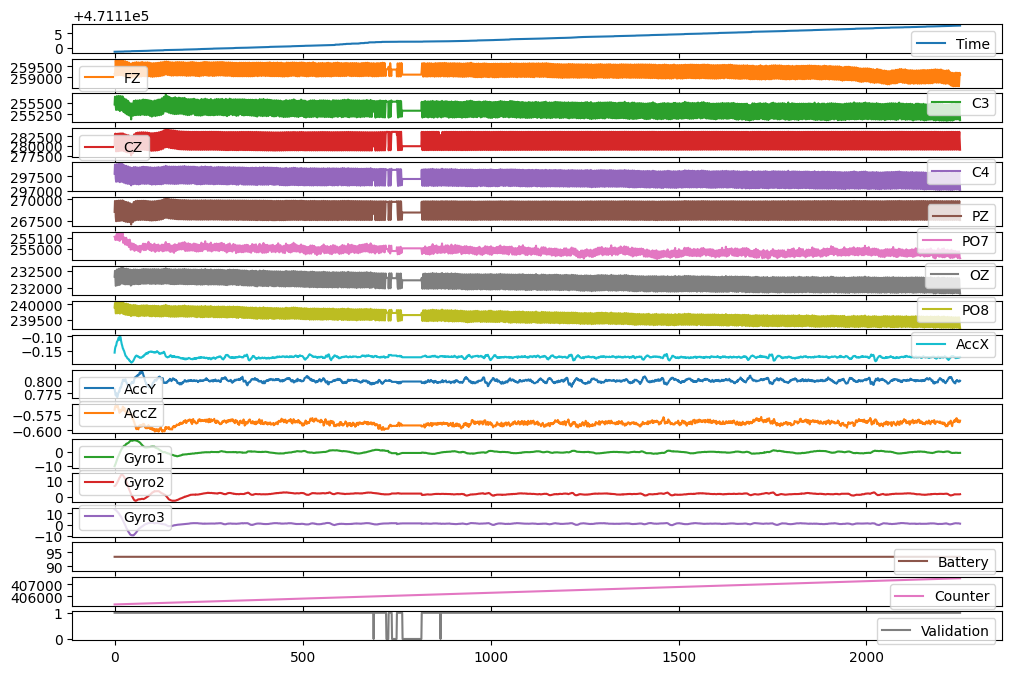

In [5]:
# 2. Preprocess the raw data by applying the filter
print("\n2. Applying Band-Pass Filter")
# Use different frequency ranges for MI and SSVEP for better results
if trial_row['task'] == 'MI':
    # For Motor Imagery, focus on the 8-30 Hz range
    filtered_eeg_data = bandpass_filter(eeg_data, low_cut=8.0, high_cut=30.0)
    print("Applied MI filter (8-30 Hz).")
else: # For SSVEP
    # For SSVEP, a wider range is fine, e.g., 4-40 Hz
    filtered_eeg_data = bandpass_filter(eeg_data, low_cut=4.0, high_cut=40.0)
    print("Applied SSVEP filter (4-40 Hz).")


print("\nFiltered EEG Data (first 5 rows):")
print(filtered_eeg_data.head())

# Display the first 5 rows of EEG signals
print("First 5 rows of signals:")
print(filtered_eeg_data.head())
import matplotlib.pyplot as plt
eeg_data.plot(subplots=True, figsize=(12, 8))

In [6]:
from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import numpy as np

def process_single_trial(row, base_path):
    try:
        # Load EEG trial
        trial_data = load_trial_data_verbose(row, base_path)

        # Apply bandpass filter based on task
        if row['task'] == 'MI':
            trial_data = bandpass_filter(trial_data, low_cut=8.0, high_cut=30.0)
        else:
            trial_data = bandpass_filter(trial_data, low_cut=3.0, high_cut=40.0)

        # Extract EEG channels
        eeg_channels = trial_data.columns[1:9]
        eeg_matrix = trial_data[eeg_channels].values  # shape = (samples, channels)

        return eeg_matrix, row['label']
    except Exception as e:
        print(f"Failed at ID {row['id']}: {e}")
        return None  # skip this trial

def process_all_trials_parallel(df, base_path='.', n_jobs=4):
    # Parallel processing using joblib
    results = Parallel(n_jobs=n_jobs)(
        delayed(process_single_trial)(row, base_path) for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing in Parallel")
    )

    # Filter out None results
    X = [r[0] for r in results if r is not None]
    y = [r[1] for r in results if r is not None]
    return X, y

# 🤖 5. Task 1: Motor Imagery (MI) Classification Pipeline
### In this section, we build the model to classify imagined movements.

### 5.1. Methodology: CSP + LDA
#### Feature Extraction with Common Spatial Patterns (CSP): CSP is a powerful algorithm specifically designed for EEG analysis. It learns a set of spatial filters that maximize the variance between two classes of signals. In simple terms, it helps us find the brain regions and signal patterns that are most discriminative for left vs. right imagined movements.

#### Classification with Linear Discriminant Analysis (LDA): LDA is a simple, fast, and highly effective linear classifier that works exceptionally well with the features extracted by CSP.

In [7]:
mi_df = full_train_df[full_train_df['task'] == 'MI'].reset_index(drop=True)
ssvep_df = full_train_df[full_train_df['task'] == 'SSVEP'].reset_index(drop=True)

In [8]:
X_mi_train, y_mi_train = process_all_trials_parallel(mi_df, base_path=base_path, n_jobs=4)

Processing in Parallel:   7%|▋         | 168/2450 [00:09<01:54, 19.85it/s]

Trials Details:
- Task: MI
- Subject: S1
- Session: 1
- Trial #: 2
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S1/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S1
- Session: 1
- Trial #: 5
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S1/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S1
- Session: 1
- Trial #: 9
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S1/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S1
- Session: 2
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S1/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S1
- Session: 2
- Trial #: 7
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S1/2/EEGdata.csv
- Data Shape: (2250, 18)

Processing in Parallel:   7%|▋         | 176/2450 [00:10<01:44, 21.76it/s]

Trials Details:
- Task: MI
- Subject: S1
- Session: 1
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S1/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S1
- Session: 1
- Trial #: 7
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S1/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S1
- Session: 2
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S1/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S1
- Session: 2
- Trial #: 5
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S1/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S1
- Session: 2
- Trial #: 9
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S1/2/EEGdata.csv
- Data Shape: (2250, 18)

Processing in Parallel:  14%|█▎        | 332/2450 [00:16<01:33, 22.64it/s]



Trials Details:
- Task: MI
- Subject: S3
- Session: 1
- Trial #: 4
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S3/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S3
- Session: 1
- Trial #: 8
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S3/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S3
- Session: 2
- Trial #: 2
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S3/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S3
- Session: 2
- Trial #: 5
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S3/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S3
- Session: 2
- Trial #: 10
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S3/2/EEGdata.csv
- Data Shape: (2250, 1

Processing in Parallel:  14%|█▍        | 340/2450 [00:17<01:30, 23.25it/s]


- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S3
- Session: 1
- Trial #: 9
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S3/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S3
- Session: 2
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S3/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S3
- Session: 2
- Trial #: 7
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S3/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S3
- Session: 3
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S3/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S3
- Session: 3
- Trial #: 6
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S3/3/EEGdata.

Processing in Parallel:  20%|██        | 496/2450 [00:24<01:27, 22.36it/s]


- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S5
- Session: 1
- Trial #: 7
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S5/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S5
- Session: 2
- Trial #: 1
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S5/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S5
- Session: 2
- Trial #: 5
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S5/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S5
- Session: 2
- Trial #: 9
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S5/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S5
- Session: 3
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S5/3/EEGdata.cs

Processing in Parallel:  21%|██        | 504/2450 [00:24<01:25, 22.64it/s]


- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S5
- Session: 2
- Trial #: 3
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S5/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S5
- Session: 2
- Trial #: 7
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S5/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S5
- Session: 3
- Trial #: 1
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S5/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S5
- Session: 3
- Trial #: 5
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S5/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S5
- Session: 3
- Trial #: 9
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S5/3/EEGdata

Processing in Parallel:  27%|██▋       | 660/2450 [00:31<01:21, 21.85it/s]


- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S7
- Session: 2
- Trial #: 1
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S7/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S7
- Session: 2
- Trial #: 6
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S7/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S7
- Session: 2
- Trial #: 10
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S7/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S7
- Session: 3
- Trial #: 4
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S7/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S7
- Session: 3
- Trial #: 8
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S7/3/EEGdata.

Processing in Parallel:  27%|██▋       | 664/2450 [00:32<01:20, 22.30it/s]


- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S7
- Session: 2
- Trial #: 7
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S7/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S7
- Session: 3
- Trial #: 1
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S7/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S7
- Session: 3
- Trial #: 6
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S7/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S7
- Session: 3
- Trial #: 10
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S7/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S7
- Session: 4
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S7/4/EEGdata.

Processing in Parallel:  34%|███▎      | 824/2450 [00:39<01:19, 20.57it/s]


- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S9
- Session: 2
- Trial #: 6
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S9/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S9
- Session: 2
- Trial #: 10
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S9/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S9
- Session: 3
- Trial #: 4
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S9/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S9
- Session: 3
- Trial #: 8
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S9/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S9
- Session: 4
- Trial #: 2
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S9/4/EEGdat

Processing in Parallel:  34%|███▍      | 832/2450 [00:39<01:20, 20.07it/s]


- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S9
- Session: 3
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S9/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S9
- Session: 3
- Trial #: 7
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S9/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S9
- Session: 4
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S9/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S9
- Session: 4
- Trial #: 5
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S9/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S9
- Session: 4
- Trial #: 9
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S9/4/EEGdata.csv

Processing in Parallel:  40%|████      | 984/2450 [00:47<01:07, 21.72it/s]


- File Path: /kaggle/input/mtcaic3/MI/train/S11/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S11
- Session: 2
- Trial #: 9
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S11/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S11
- Session: 3
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S11/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S11
- Session: 3
- Trial #: 7
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S11/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S11
- Session: 4
- Trial #: 1
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S11/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S11
- Session: 4
- Trial #: 5
- Label (Target): Left
- Dataset 

Processing in Parallel:  40%|████      | 992/2450 [00:47<01:10, 20.66it/s]

- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S11/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S11
- Session: 3
- Trial #: 6
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S11/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S11
- Session: 3
- Trial #: 10
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S11/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S11
- Session: 4
- Trial #: 4
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S11/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S11
- Session: 4
- Trial #: 8
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S11/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S11
- Session: 5
- Trial #: 2
- Label (

Processing in Parallel:  47%|████▋     | 1144/2450 [00:54<00:55, 23.61it/s]


- Task: MI
- Subject: S13
- Session: 2
- Trial #: 7
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S13/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S13
- Session: 3
- Trial #: 1
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S13/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S13
- Session: 3
- Trial #: 5
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S13/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S13
- Session: 3
- Trial #: 9
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S13/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S13
- Session: 4
- Trial #: 4
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S13/4/EEGdata.csv
- Data Shape: (2250, 18)

T

Processing in Parallel:  47%|████▋     | 1156/2450 [00:55<00:55, 23.52it/s]



Trials Details:
- Task: MI
- Subject: S13
- Session: 3
- Trial #: 6
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S13/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S13
- Session: 3
- Trial #: 10
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S13/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S13
- Session: 4
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S13/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S13
- Session: 4
- Trial #: 7
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S13/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S13
- Session: 5
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S13/5/EEGdata.csv
- Data Shape

Processing in Parallel:  53%|█████▎    | 1304/2450 [01:01<00:48, 23.42it/s]


- File Path: /kaggle/input/mtcaic3/MI/train/S15/2/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S15
- Session: 3
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S15/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S15
- Session: 3
- Trial #: 5
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S15/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S15
- Session: 3
- Trial #: 10
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S15/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S15
- Session: 4
- Trial #: 4
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S15/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S15
- Session: 4
- Trial #: 8
- Label (Target): Left
- Dataset S

Processing in Parallel:  54%|█████▎    | 1316/2450 [01:02<00:49, 23.11it/s]


- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S15/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S15
- Session: 3
- Trial #: 9
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S15/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S15
- Session: 4
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S15/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S15
- Session: 4
- Trial #: 7
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S15/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S15
- Session: 5
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S15/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S15
- Session: 5
- Trial #: 5
- Label (Tar

Processing in Parallel:  60%|██████    | 1472/2450 [01:09<00:43, 22.39it/s]



Trials Details:
- Task: MI
- Subject: S17
- Session: 3
- Trial #: 1
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S17/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S17
- Session: 3
- Trial #: 5
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S17/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S17
- Session: 3
- Trial #: 9
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S17/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S17
- Session: 4
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S17/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S17
- Session: 4
- Trial #: 7
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S17/4/EEGdata.csv
- Data Shape

Processing in Parallel:  60%|██████    | 1480/2450 [01:09<00:41, 23.51it/s]



Trials Details:
- Task: MI
- Subject: S17
- Session: 3
- Trial #: 10
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S17/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S17
- Session: 4
- Trial #: 4
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S17/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S17
- Session: 4
- Trial #: 8
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S17/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S17
- Session: 5
- Trial #: 2
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S17/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S17
- Session: 5
- Trial #: 5
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S17/5/EEGdata.csv
- Data Sha

Processing in Parallel:  67%|██████▋   | 1632/2450 [01:16<00:37, 22.09it/s]


- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S19/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S19
- Session: 3
- Trial #: 8
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S19/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S19
- Session: 4
- Trial #: 2
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S19/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S19
- Session: 4
- Trial #: 6
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S19/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S19
- Session: 4
- Trial #: 10
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S19/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S19
- Session: 

Processing in Parallel:  67%|██████▋   | 1640/2450 [01:16<00:34, 23.60it/s]


- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S19/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S19
- Session: 4
- Trial #: 3
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S19/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S19
- Session: 4
- Trial #: 7
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S19/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S19
- Session: 5
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S19/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S19
- Session: 5
- Trial #: 6
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S19/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S19
- Session: 6
- Trial #: 1
- Label (T

Processing in Parallel:  73%|███████▎  | 1796/2450 [01:23<00:29, 22.37it/s]



Trials Details:
- Task: MI
- Subject: S21
- Session: 3
- Trial #: 5
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S21/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S21
- Session: 3
- Trial #: 9
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S21/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S21
- Session: 4
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S21/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S21
- Session: 4
- Trial #: 7
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S21/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S21
- Session: 5
- Trial #: 1
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S21/5/EEGdata.csv
- Data Shap

Processing in Parallel:  74%|███████▎  | 1804/2450 [01:23<00:28, 22.29it/s]


- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S21
- Session: 4
- Trial #: 6
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S21/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S21
- Session: 4
- Trial #: 10
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S21/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S21
- Session: 5
- Trial #: 4
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S21/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S21
- Session: 5
- Trial #: 8
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S21/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S21
- Session: 6
- Trial #: 2
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S21

Processing in Parallel:  80%|███████▉  | 1956/2450 [01:30<00:22, 22.19it/s]


- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S23/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S23
- Session: 3
- Trial #: 9
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S23/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S23
- Session: 4
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S23/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S23
- Session: 4
- Trial #: 7
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S23/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S23
- Session: 5
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S23/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S23
- Session: 5
- Trial #: 6
- Label (Tar

Processing in Parallel:  80%|████████  | 1964/2450 [01:31<00:21, 22.28it/s]


- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S23/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S23
- Session: 4
- Trial #: 8
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S23/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S23
- Session: 5
- Trial #: 2
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S23/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S23
- Session: 5
- Trial #: 5
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S23/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S23
- Session: 5
- Trial #: 9
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S23/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S23
- Session: 6

Processing in Parallel:  87%|████████▋ | 2120/2450 [01:37<00:13, 23.89it/s]



Trials Details:
- Task: MI
- Subject: S25
- Session: 3
- Trial #: 10
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S25/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S25
- Session: 4
- Trial #: 4
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S25/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S25
- Session: 4
- Trial #: 8
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S25/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S25
- Session: 5
- Trial #: 2
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S25/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S25
- Session: 5
- Trial #: 6
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S25/5/EEGdata.csv
- Data Sh

Processing in Parallel:  87%|████████▋ | 2124/2450 [01:37<00:13, 23.65it/s]

Trials Details:
- Task: MI
- Subject: S25
- Session: 4
- Trial #: 10
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S25/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S25
- Session: 5
- Trial #: 4
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S25/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S25
- Session: 5
- Trial #: 8
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S25/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S25
- Session: 6
- Trial #: 2
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S25/6/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S25
- Session: 6
- Trial #: 6
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S25/6/EEGdata.csv
- Data Shape

Processing in Parallel:  93%|█████████▎| 2276/2450 [01:44<00:07, 23.82it/s]


- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/3/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 4
- Trial #: 3
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 4
- Trial #: 6
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 4
- Trial #: 9
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 5
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 5
- Trial #: 7
- Label (T

Processing in Parallel:  93%|█████████▎| 2284/2450 [01:44<00:06, 24.11it/s]


- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 4
- Trial #: 7
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 5
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 5
- Trial #: 5
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 5
- Trial #: 9
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 6

Processing in Parallel:  93%|█████████▎| 2288/2450 [01:45<00:07, 22.32it/s]


- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 5
- Trial #: 4
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 5
- Trial #: 8
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 6
- Trial #: 2
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/6/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 6
- Trial #: 5
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S27/6/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S27
- Session: 6

Processing in Parallel:  99%|█████████▉| 2436/2450 [01:51<00:00, 24.47it/s]


- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 4
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 4
- Trial #: 5
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 4
- Trial #: 9
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 5
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 5
- Trial #: 7
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/5/

Processing in Parallel: 100%|█████████▉| 2444/2450 [01:51<00:00, 25.20it/s]


- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 4
- Trial #: 7
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/4/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 5
- Trial #: 1
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 5
- Trial #: 6
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 5
- Trial #: 10
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 6
- Trial #: 4
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S2

Processing in Parallel: 100%|██████████| 2450/2450 [01:51<00:00, 21.93it/s]



Trials Details:
- Task: MI
- Subject: S29
- Session: 5
- Trial #: 2
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 5
- Trial #: 5
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 5
- Trial #: 9
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/5/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 6
- Trial #: 3
- Label (Target): Left
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/6/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S29
- Session: 6
- Trial #: 7
- Label (Target): Right
- Dataset Split: train
- File Path: /kaggle/input/mtcaic3/MI/train/S29/6/EEGdata.csv
- Data Shape

In [ ]:
X_ssvep_train, y_ssvep_train = process_all_trials_parallel(ssvep_df, base_path=base_path, n_jobs=4)

In [10]:
# Extract subject_id to use as the grouping key
mi_subjects = mi_df['subject_id'].values

### 5.2. Implementation & Cross-Validation
#### We will now process all MI trials, extract features using the CSP+LDA pipeline, and evaluate the performance using a 5-fold cross-validation grouped by subject.

In [11]:
from sklearn.model_selection import StratifiedGroupKFold

# Create the cross-validator
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)


In [12]:
# MI
from sklearn.calibration import LabelEncoder

X_mi_array = np.stack(X_mi_train)
le_mi = LabelEncoder()
y_mi_encoded = le_mi.fit_transform(y_mi_train)

# SSVEP
X_ssvep_array = np.stack(X_ssvep_train)
le_ssvep = LabelEncoder()
y_ssvep_encoded = le_ssvep.fit_transform(y_ssvep_train)

print(f"✅ MI X shape: {X_mi_array.shape}, y shape: {y_mi_encoded.shape}, classes: {le_mi.classes_}")
print(f"✅ SSVEP X shape: {X_ssvep_array.shape}, y shape: {y_ssvep_encoded.shape}, classes: {le_ssvep.classes_}")


✅ MI X shape: (2450, 2250, 8), y shape: (2450,), classes: ['Left' 'Right']
✅ SSVEP X shape: (2450, 1750, 8), y shape: (2450,), classes: ['Backward' 'Forward' 'Left' 'Right']


### 5.3. MI Results
#### The performance of our MI pipeline is evaluated using the macro F1-score.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import f1_score
from mne.decoding import CSP

csp_f1_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_mi_array, y_mi_encoded, groups=mi_subjects)):
    print(f"Fold {fold + 1}")

    # Split the data
    X_train, X_val = X_mi_array[train_idx], X_mi_array[val_idx]
    y_train, y_val = y_mi_encoded[train_idx], y_mi_encoded[val_idx]

    # Transpose to (n_trials, n_channels, n_times)
    X_train_csp = X_train.transpose(0, 2, 1)
    X_val_csp = X_val.transpose(0, 2, 1)

    # CSP + LDA pipeline with regularization and fewer components
    clf = Pipeline([
        ('csp', CSP(n_components=4, reg='ledoit_wolf', log=True, norm_trace=False)),
        ('lda', LinearDiscriminantAnalysis())
    ])

    # Train and evaluate
    clf.fit(X_train_csp, y_train)
    y_pred = clf.predict(X_val_csp)
    f1 = f1_score(y_val, y_pred, average='macro')
    csp_f1_scores.append(f1)
    print(f"F1 Macro: {f1:.4f}")

# Overall CV F1 score
mi_f1_macro = np.max(csp_f1_scores)
print(f"\nmax MI F1 Macro (CSP + LDA): {mi_f1_macro:.4f}")


Fold 1
Computing rank from data with rank=None
    Using tolerance 1.8e+03 (2.2e-16 eps * 8 dim * 1e+18  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
F1 Macro: 0.4712
Fold 2
Computing rank from data with rank=None
    Using tolerance 1.8e+03 (2.2e-16 eps * 8 dim * 1e+18  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 8
Estimating class=0 covariance using LEDOIT_WOLF
Done.
Estimating class=1 covariance using LEDOIT_WOLF
Done.
F1 Macro: 0.4939
Fold 3
Computing rank from data with rank=None
    Using tolerance 1.6e+03 (2.2e-16 eps * 8 dim * 8.9e+17  max singular value)
    Estimated rank (data): 8
    data: rank 8 computed from 8 data channels with 0 projectors
Reducing data rank from 8 -> 

# 👁️ 6. Task 2: SSVEP Classification Pipeline
### Now, we tackle the SSVEP task, which involves identifying which visual target a user is focusing on.

### 6.1. Methodology: Canonical Correlation Analysis (CCA)
#### Canonical Correlation Analysis (CCA) is the state-of-the-art method for SSVEP classification. The logic is elegant:

#### We generate pure sine/cosine waves (reference signals) at the exact frequencies of the visual stimuli (e.g., 7 Hz, 8 Hz, 10 Hz, 13 Hz).
#### For each EEG trial, CCA calculates the correlation between the brain signal and each of the reference signals.
#### The predicted class is simply the frequency of the reference signal that has the highest correlation with the EEG signal.

### 6.2. Implementation & Cross-Validation
#### We will implement the CCA-based prediction and evaluate its performance using the same cross-validation strategy.

In [14]:
ssvep_subjects = ssvep_df['subject_id'].values  # Needed for GroupKFold

In [15]:
from sklearn.cross_decomposition import CCA
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedGroupKFold

def generate_reference_signals(frequencies, n_samples, fs=250, harmonics=2):
    t = np.arange(n_samples) / fs
    ref_signals = {}
    for freq in frequencies:
        ref = []
        for h in range(1, harmonics + 1):
            ref.append(np.sin(2 * np.pi * h * freq * t))
            ref.append(np.cos(2 * np.pi * h * freq * t))
        ref_signals[freq] = np.stack(ref, axis=1)
    return ref_signals


In [16]:
# The CORRECT frequencies
label_to_freq = {
    0: 8.0,   # Backward
    1: 7.0,   # Forward
    2: 10.0,  # Left
    3: 13.0,  # Right
}

In [17]:
def predict_ssvep_label(trial_data, ref_signals):
    cca = CCA(n_components=1)
    best_corr = -np.inf
    best_label = None
    for label, ref in ref_signals.items():
        try:
            cca.fit(trial_data, ref)
            X_c, Y_c = cca.transform(trial_data, ref)
            corr = np.corrcoef(X_c.T, Y_c.T)[0, 1]
            if corr > best_corr:
                best_corr = corr
                best_label = label
        except Exception:
            continue
    return best_label


### 6.3. SSVEP Results
#### The performance is also measured by the macro F1-score.

In [18]:
freqs = [label_to_freq[label] for label in sorted(label_to_freq)]
ref_signals = generate_reference_signals(freqs, X_ssvep_array.shape[1], fs=250, harmonics=4)

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
ssvep_f1_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X_ssvep_array, y_ssvep_encoded, groups=ssvep_subjects)):
    print(f"Fold {fold + 1}")

    X_val = X_ssvep_array[val_idx]
    y_val = y_ssvep_encoded[val_idx]

    preds = []
    for trial in X_val:
        pred = predict_ssvep_label(trial, {lbl: ref_signals[freq] for lbl, freq in label_to_freq.items()})
        preds.append(pred)

    f1 = f1_score(y_val, preds, average='macro')
    ssvep_f1_scores.append(f1)
    print(f"F1 Macro: {f1:.4f}")

ssvep_f1_macro = np.max(ssvep_f1_scores)
print(f"\nMax SSVEP F1 Macro (CCA): {ssvep_f1_macro:.4f}")


Fold 1
F1 Macro: 0.4075
Fold 2
F1 Macro: 0.6023
Fold 3
F1 Macro: 0.4265
Fold 4
F1 Macro: 0.5526
Fold 5
F1 Macro: 0.4998

Max SSVEP F1 Macro (CCA): 0.6023


# 🏆 7. Final Score & Submission
### The final competition score is the average of the macro F1-scores from both tasks. We will now apply our trained pipelines to the test set and generate the submission file.

In [19]:
competition_score = 0.5 * (mi_f1_macro + ssvep_f1_macro)
print(f"\nFinal Competition Score 🏆🏆🏆 = {competition_score:.4f}")


Final Competition Score 🏆🏆🏆 = 0.5761


In [20]:
# Separate MI and SSVEP test data
mi_test_df = test_df[test_df['task'] == 'MI'].reset_index(drop=True)
ssvep_test_df = test_df[test_df['task'] == 'SSVEP'].reset_index(drop=True)

# Preprocess test data
X_mi_test, mi_test_ids = [], []
for _, row in tqdm(mi_test_df.iterrows(), total=len(mi_test_df)):
    eeg = load_trial_data_verbose(row, base_path)
    eeg = bandpass_filter(eeg, low_cut=8, high_cut=30)
    X_mi_test.append(eeg.iloc[:, 1:9].values)
    mi_test_ids.append(row['id'])

X_ssvep_test, ssvep_test_ids = [], []
for _, row in tqdm(ssvep_test_df.iterrows(), total=len(ssvep_test_df)):
    eeg = load_trial_data_verbose(row, base_path)
    eeg = bandpass_filter(eeg, low_cut=4, high_cut=40)
    X_ssvep_test.append(eeg.iloc[:, 1:9].values)
    ssvep_test_ids.append(row['id'])


  6%|▌         | 3/50 [00:00<00:05,  8.32it/s]

Trials Details:
- Task: MI
- Subject: S36
- Session: 1
- Trial #: 1
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S36/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S36
- Session: 1
- Trial #: 2
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S36/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S36
- Session: 1
- Trial #: 3
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S36/1/EEGdata.csv
- Data Shape: (2250, 18)



 10%|█         | 5/50 [00:00<00:04,  9.59it/s]

Trials Details:
- Task: MI
- Subject: S36
- Session: 1
- Trial #: 4
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S36/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S36
- Session: 1
- Trial #: 5
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S36/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S36
- Session: 1
- Trial #: 6
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S36/1/EEGdata.csv
- Data Shape: (2250, 18)



 18%|█▊        | 9/50 [00:00<00:03, 10.98it/s]

Trials Details:
- Task: MI
- Subject: S36
- Session: 1
- Trial #: 7
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S36/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S36
- Session: 1
- Trial #: 8
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S36/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S36
- Session: 1
- Trial #: 9
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S36/1/EEGdata.csv
- Data Shape: (2250, 18)



 22%|██▏       | 11/50 [00:01<00:03, 10.05it/s]

Trials Details:
- Task: MI
- Subject: S36
- Session: 1
- Trial #: 10
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S36/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S37
- Session: 1
- Trial #: 1
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S37/1/EEGdata.csv
- Data Shape: (2250, 18)



 26%|██▌       | 13/50 [00:01<00:03, 10.32it/s]

Trials Details:
- Task: MI
- Subject: S37
- Session: 1
- Trial #: 2
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S37/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S37
- Session: 1
- Trial #: 3
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S37/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S37
- Session: 1
- Trial #: 4
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S37/1/EEGdata.csv
- Data Shape: (2250, 18)



 34%|███▍      | 17/50 [00:01<00:03, 10.66it/s]

Trials Details:
- Task: MI
- Subject: S37
- Session: 1
- Trial #: 5
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S37/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S37
- Session: 1
- Trial #: 6
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S37/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S37
- Session: 1
- Trial #: 7
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S37/1/EEGdata.csv
- Data Shape: (2250, 18)



 38%|███▊      | 19/50 [00:01<00:02, 10.73it/s]

Trials Details:
- Task: MI
- Subject: S37
- Session: 1
- Trial #: 8
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S37/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S37
- Session: 1
- Trial #: 9
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S37/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S37
- Session: 1
- Trial #: 10
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S37/1/EEGdata.csv
- Data Shape: (2250, 18)



 46%|████▌     | 23/50 [00:02<00:02, 10.14it/s]

Trials Details:
- Task: MI
- Subject: S38
- Session: 1
- Trial #: 1
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S38/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S38
- Session: 1
- Trial #: 2
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S38/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S38
- Session: 1
- Trial #: 3
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S38/1/EEGdata.csv
- Data Shape: (2250, 18)



 50%|█████     | 25/50 [00:02<00:02, 10.36it/s]

Trials Details:
- Task: MI
- Subject: S38
- Session: 1
- Trial #: 4
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S38/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S38
- Session: 1
- Trial #: 5
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S38/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S38
- Session: 1
- Trial #: 6
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S38/1/EEGdata.csv
- Data Shape: (2250, 18)



 58%|█████▊    | 29/50 [00:02<00:01, 10.75it/s]

Trials Details:
- Task: MI
- Subject: S38
- Session: 1
- Trial #: 7
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S38/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S38
- Session: 1
- Trial #: 8
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S38/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S38
- Session: 1
- Trial #: 9
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S38/1/EEGdata.csv
- Data Shape: (2250, 18)



 62%|██████▏   | 31/50 [00:03<00:01,  9.86it/s]

Trials Details:
- Task: MI
- Subject: S38
- Session: 1
- Trial #: 10
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S38/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S39
- Session: 1
- Trial #: 1
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S39/1/EEGdata.csv
- Data Shape: (2250, 18)



 66%|██████▌   | 33/50 [00:03<00:01, 10.12it/s]

Trials Details:
- Task: MI
- Subject: S39
- Session: 1
- Trial #: 2
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S39/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S39
- Session: 1
- Trial #: 3
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S39/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S39
- Session: 1
- Trial #: 4
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S39/1/EEGdata.csv
- Data Shape: (2250, 18)



 74%|███████▍  | 37/50 [00:03<00:01, 10.80it/s]

Trials Details:
- Task: MI
- Subject: S39
- Session: 1
- Trial #: 5
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S39/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S39
- Session: 1
- Trial #: 6
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S39/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S39
- Session: 1
- Trial #: 7
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S39/1/EEGdata.csv
- Data Shape: (2250, 18)



 78%|███████▊  | 39/50 [00:03<00:01, 10.97it/s]

Trials Details:
- Task: MI
- Subject: S39
- Session: 1
- Trial #: 8
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S39/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S39
- Session: 1
- Trial #: 9
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S39/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S39
- Session: 1
- Trial #: 10
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S39/1/EEGdata.csv
- Data Shape: (2250, 18)



 86%|████████▌ | 43/50 [00:04<00:00, 10.09it/s]

Trials Details:
- Task: MI
- Subject: S40
- Session: 1
- Trial #: 1
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S40/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S40
- Session: 1
- Trial #: 2
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S40/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S40
- Session: 1
- Trial #: 3
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S40/1/EEGdata.csv
- Data Shape: (2250, 18)



 90%|█████████ | 45/50 [00:04<00:00, 10.17it/s]

Trials Details:
- Task: MI
- Subject: S40
- Session: 1
- Trial #: 4
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S40/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S40
- Session: 1
- Trial #: 5
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S40/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S40
- Session: 1
- Trial #: 6
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S40/1/EEGdata.csv
- Data Shape: (2250, 18)



 98%|█████████▊| 49/50 [00:04<00:00, 10.42it/s]

Trials Details:
- Task: MI
- Subject: S40
- Session: 1
- Trial #: 7
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S40/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S40
- Session: 1
- Trial #: 8
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S40/1/EEGdata.csv
- Data Shape: (2250, 18)

Trials Details:
- Task: MI
- Subject: S40
- Session: 1
- Trial #: 9
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S40/1/EEGdata.csv
- Data Shape: (2250, 18)



100%|██████████| 50/50 [00:04<00:00, 10.27it/s]


Trials Details:
- Task: MI
- Subject: S40
- Session: 1
- Trial #: 10
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/MI/test/S40/1/EEGdata.csv
- Data Shape: (2250, 18)



  2%|▏         | 1/50 [00:00<00:05,  8.62it/s]

Trials Details:
- Task: SSVEP
- Subject: S36
- Session: 1
- Trial #: 1
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S36/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S36
- Session: 1
- Trial #: 2
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S36/1/EEGdata.csv
- Data Shape: (1750, 18)



  6%|▌         | 3/50 [00:00<00:03, 12.13it/s]

Trials Details:
- Task: SSVEP
- Subject: S36
- Session: 1
- Trial #: 3
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S36/1/EEGdata.csv
- Data Shape: (1750, 18)



 10%|█         | 5/50 [00:00<00:03, 12.65it/s]

Trials Details:
- Task: SSVEP
- Subject: S36
- Session: 1
- Trial #: 4
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S36/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S36
- Session: 1
- Trial #: 5
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S36/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S36
- Session: 1
- Trial #: 6
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S36/1/EEGdata.csv
- Data Shape: (1750, 18)



 14%|█▍        | 7/50 [00:00<00:03, 13.03it/s]

Trials Details:
- Task: SSVEP
- Subject: S36
- Session: 1
- Trial #: 7
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S36/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S36
- Session: 1
- Trial #: 8
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S36/1/EEGdata.csv
- Data Shape: (1750, 18)



 18%|█▊        | 9/50 [00:00<00:03, 13.48it/s]

Trials Details:
- Task: SSVEP
- Subject: S36
- Session: 1
- Trial #: 9
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S36/1/EEGdata.csv
- Data Shape: (1750, 18)



 22%|██▏       | 11/50 [00:00<00:03, 12.58it/s]

Trials Details:
- Task: SSVEP
- Subject: S36
- Session: 1
- Trial #: 10
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S36/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S37
- Session: 1
- Trial #: 1
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S37/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S37
- Session: 1
- Trial #: 2
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S37/1/EEGdata.csv
- Data Shape: (1750, 18)



 26%|██▌       | 13/50 [00:01<00:02, 12.96it/s]

Trials Details:
- Task: SSVEP
- Subject: S37
- Session: 1
- Trial #: 3
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S37/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S37
- Session: 1
- Trial #: 4
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S37/1/EEGdata.csv
- Data Shape: (1750, 18)



 30%|███       | 15/50 [00:01<00:02, 13.31it/s]

Trials Details:
- Task: SSVEP
- Subject: S37
- Session: 1
- Trial #: 5
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S37/1/EEGdata.csv
- Data Shape: (1750, 18)



 34%|███▍      | 17/50 [00:01<00:02, 13.65it/s]

Trials Details:
- Task: SSVEP
- Subject: S37
- Session: 1
- Trial #: 6
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S37/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S37
- Session: 1
- Trial #: 7
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S37/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S37
- Session: 1
- Trial #: 8
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S37/1/EEGdata.csv
- Data Shape: (1750, 18)



 38%|███▊      | 19/50 [00:01<00:02, 13.42it/s]

Trials Details:
- Task: SSVEP
- Subject: S37
- Session: 1
- Trial #: 9
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S37/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S37
- Session: 1
- Trial #: 10
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S37/1/EEGdata.csv
- Data Shape: (1750, 18)



 42%|████▏     | 21/50 [00:01<00:02, 12.51it/s]

Trials Details:
- Task: SSVEP
- Subject: S38
- Session: 1
- Trial #: 1
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S38/1/EEGdata.csv
- Data Shape: (1750, 18)



 46%|████▌     | 23/50 [00:01<00:02, 12.86it/s]

Trials Details:
- Task: SSVEP
- Subject: S38
- Session: 1
- Trial #: 2
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S38/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S38
- Session: 1
- Trial #: 3
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S38/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S38
- Session: 1
- Trial #: 4
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S38/1/EEGdata.csv
- Data Shape: (1750, 18)



 50%|█████     | 25/50 [00:01<00:01, 13.00it/s]

Trials Details:
- Task: SSVEP
- Subject: S38
- Session: 1
- Trial #: 5
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S38/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S38
- Session: 1
- Trial #: 6
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S38/1/EEGdata.csv
- Data Shape: (1750, 18)



 54%|█████▍    | 27/50 [00:02<00:01, 12.99it/s]

Trials Details:
- Task: SSVEP
- Subject: S38
- Session: 1
- Trial #: 7
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S38/1/EEGdata.csv
- Data Shape: (1750, 18)



 58%|█████▊    | 29/50 [00:02<00:01, 13.28it/s]

Trials Details:
- Task: SSVEP
- Subject: S38
- Session: 1
- Trial #: 8
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S38/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S38
- Session: 1
- Trial #: 9
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S38/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S38
- Session: 1
- Trial #: 10
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S38/1/EEGdata.csv
- Data Shape: (1750, 18)



 62%|██████▏   | 31/50 [00:02<00:01, 12.21it/s]

Trials Details:
- Task: SSVEP
- Subject: S39
- Session: 1
- Trial #: 1
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S39/1/EEGdata.csv
- Data Shape: (1750, 18)



 66%|██████▌   | 33/50 [00:02<00:01, 12.55it/s]

Trials Details:
- Task: SSVEP
- Subject: S39
- Session: 1
- Trial #: 2
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S39/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S39
- Session: 1
- Trial #: 3
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S39/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S39
- Session: 1
- Trial #: 4
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S39/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S39
- Session: 1
- Trial #: 5
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S39/1/EEGdata.csv
- Data Shape: (1750, 18)



 74%|███████▍  | 37/50 [00:02<00:00, 13.87it/s]

Trials Details:
- Task: SSVEP
- Subject: S39
- Session: 1
- Trial #: 6
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S39/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S39
- Session: 1
- Trial #: 7
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S39/1/EEGdata.csv
- Data Shape: (1750, 18)



 78%|███████▊  | 39/50 [00:02<00:00, 14.33it/s]

Trials Details:
- Task: SSVEP
- Subject: S39
- Session: 1
- Trial #: 8
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S39/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S39
- Session: 1
- Trial #: 9
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S39/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S39
- Session: 1
- Trial #: 10
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S39/1/EEGdata.csv
- Data Shape: (1750, 18)



 82%|████████▏ | 41/50 [00:03<00:00, 13.30it/s]

Trials Details:
- Task: SSVEP
- Subject: S40
- Session: 1
- Trial #: 1
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S40/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S40
- Session: 1
- Trial #: 2
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S40/1/EEGdata.csv
- Data Shape: (1750, 18)



 86%|████████▌ | 43/50 [00:03<00:00, 13.85it/s]

Trials Details:
- Task: SSVEP
- Subject: S40
- Session: 1
- Trial #: 3
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S40/1/EEGdata.csv
- Data Shape: (1750, 18)



 90%|█████████ | 45/50 [00:03<00:00, 13.73it/s]

Trials Details:
- Task: SSVEP
- Subject: S40
- Session: 1
- Trial #: 4
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S40/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S40
- Session: 1
- Trial #: 5
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S40/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S40
- Session: 1
- Trial #: 6
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S40/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S40
- Session: 1
- Trial #: 7
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S40/1/EEGdata.csv
- Data Shape: (1750, 18)



 98%|█████████▊| 49/50 [00:03<00:00, 14.47it/s]

Trials Details:
- Task: SSVEP
- Subject: S40
- Session: 1
- Trial #: 8
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S40/1/EEGdata.csv
- Data Shape: (1750, 18)

Trials Details:
- Task: SSVEP
- Subject: S40
- Session: 1
- Trial #: 9
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S40/1/EEGdata.csv
- Data Shape: (1750, 18)



100%|██████████| 50/50 [00:03<00:00, 13.33it/s]

Trials Details:
- Task: SSVEP
- Subject: S40
- Session: 1
- Trial #: 10
- Label (Target): Not Available (Test set)
- Dataset Split: test
- File Path: /kaggle/input/mtcaic3/SSVEP/test/S40/1/EEGdata.csv
- Data Shape: (1750, 18)



In [21]:
X_mi_test_array = np.stack(X_mi_test).transpose(0, 2, 1)
mi_preds = clf.predict(X_mi_test_array)
mi_preds_labels = le_mi.inverse_transform(mi_preds)

In [22]:
ssvep_preds = []
for trial in X_ssvep_test:
    pred = predict_ssvep_label(trial, {lbl: ref_signals[freq] for lbl, freq in label_to_freq.items()})
    ssvep_preds.append(pred)
ssvep_preds_labels = le_ssvep.inverse_transform(ssvep_preds)


In [23]:
# Combine predictions
submission = pd.DataFrame(columns=["id", "label"])
submission = pd.concat([
    pd.DataFrame({"id": mi_test_ids, "label": mi_preds_labels}),
    pd.DataFrame({"id": ssvep_test_ids, "label": ssvep_preds_labels})
], ignore_index=True)

# Make sure order matches the sample_submission.csv
sample_sub_path = os.path.join(base_path, "sample_submission.csv")
sample_sub = pd.read_csv(sample_sub_path)

# Merge based on 'id' to ensure correct order
final_sub = sample_sub[['id']].merge(submission, on="id", how="left")

# Save to CSV
final_sub.to_csv("submission1.csv", index=False)
print("Submission file saved: submission1.csv")


Submission file saved: submission1.csv


# 🏁 8. Conclusion
### This notebook successfully implemented two specialized pipelines for classifying EEG signals from MI and SSVEP tasks. By leveraging domain-specific algorithms like CSP and CCA, we were able to build effective models that can decode brain activity with high accuracy. This project highlights the importance of tailoring the machine learning approach to the unique characteristics of the data and the problem domain.